In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import os
import random
import numpy as np
from PIL import Image

[[655.88824 667.3018  672.20325 ... 762.736   746.10645 726.43567]
 [654.2042  672.6708  670.3827  ... 772.4753  760.56104 745.2717 ]
 [663.35455 677.5574  672.5851  ... 769.8733  771.2536  759.21954]
 ...
 [553.71985 543.2438  538.3921  ... 673.37744 664.49335 662.9086 ]
 [554.19226 555.56024 546.1579  ... 673.9904  666.188   659.89233]
 [581.469   562.15295 551.1051  ... 678.09894 667.62    666.91364]] 522.50165 938.3301


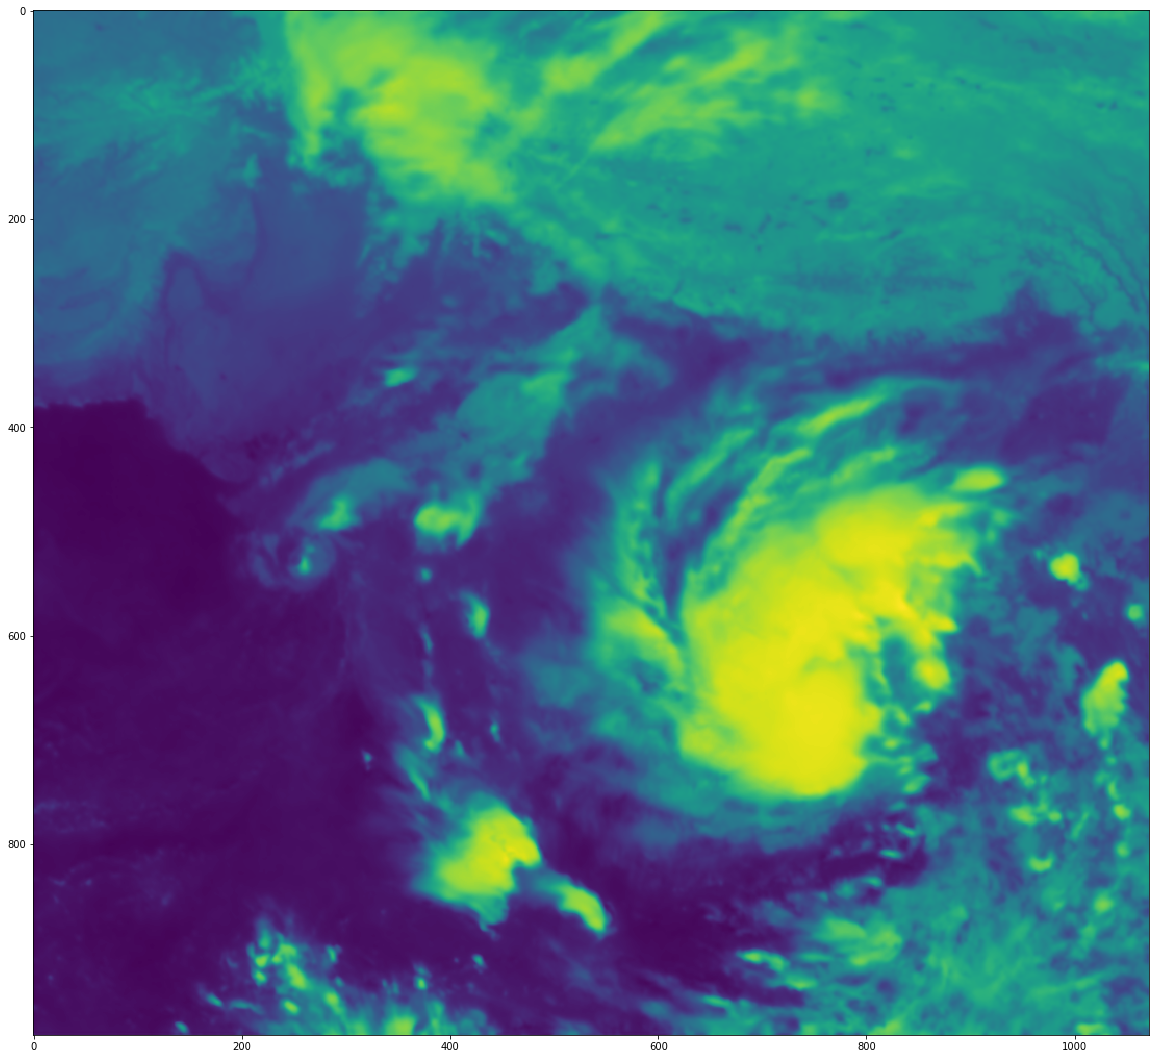

In [9]:
img = np.array(Image.open("./../results/unet_pred.tif"))
print(img,np.min(img),np.max(img))
plt.figure(figsize=(20,20))
plt.imshow(img)

#gt = np.array(Image.open("./INSAT3D_TIR1_India/3DIMG_07NOV2019_1600_L1C_SGP.tif"))
#print(gt,np.min(gt),np.max(gt))
#plt.imshow(gt)

In [2]:
files = os.listdir("./INSAT3D_TIR1_India")
files.sort()
print(files)
tir_to_num = {}
for num,file in enumerate(files):
    tir_to_num[file] = num + 1

['3DIMG_07NOV2019_0000_L1C_SGP.tif', '3DIMG_07NOV2019_0030_L1C_SGP.tif', '3DIMG_07NOV2019_0100_L1C_SGP.tif', '3DIMG_07NOV2019_0130_L1C_SGP.tif', '3DIMG_07NOV2019_0200_L1C_SGP.tif', '3DIMG_07NOV2019_0230_L1C_SGP.tif', '3DIMG_07NOV2019_0300_L1C_SGP.tif', '3DIMG_07NOV2019_0330_L1C_SGP.tif', '3DIMG_07NOV2019_0400_L1C_SGP.tif', '3DIMG_07NOV2019_0430_L1C_SGP.tif', '3DIMG_07NOV2019_0500_L1C_SGP.tif', '3DIMG_07NOV2019_0530_L1C_SGP.tif', '3DIMG_07NOV2019_0600_L1C_SGP.tif', '3DIMG_07NOV2019_0630_L1C_SGP.tif', '3DIMG_07NOV2019_0700_L1C_SGP.tif', '3DIMG_07NOV2019_0730_L1C_SGP.tif', '3DIMG_07NOV2019_0800_L1C_SGP.tif', '3DIMG_07NOV2019_0830_L1C_SGP.tif', '3DIMG_07NOV2019_0859_L1C_SGP.tif', '3DIMG_07NOV2019_0900_L1C_SGP.tif', '3DIMG_07NOV2019_0929_L1C_SGP.tif', '3DIMG_07NOV2019_0930_L1C_SGP.tif', '3DIMG_07NOV2019_0959_L1C_SGP.tif', '3DIMG_07NOV2019_1000_L1C_SGP.tif', '3DIMG_07NOV2019_1030_L1C_SGP.tif', '3DIMG_07NOV2019_1100_L1C_SGP.tif', '3DIMG_07NOV2019_1130_L1C_SGP.tif', '3DIMG_07NOV2019_1200_L1C_S

In [3]:
files = os.listdir("./INSAT3D_VIS_India")
files.sort()
vis_to_num = {}
for num,file in enumerate(files):
    vis_to_num[file] = num + 1

In [4]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self,file_list,arg, name_to_num = None, transform=None):
        self.file_list = file_list
        self.arg = arg
        self.transform = transform
        self.name_to_num = name_to_num

        
    def __len__(self):
        return len(self.file_list[0]) if self.arg == 'fusion' else len(self.file_list)
    
    def __getitem__(self, idx):
        if self.arg == 'fusion':
            image1 = np.array(Image.open(f'./INSAT3D_VIS_India/{self.file_list[0][idx]}'))[:,:1072]
            image1 = image1.astype(np.float)
            
            image2 = np.array(Image.open(f'./INSAT3D_TIR1_India/{self.file_list[1][idx]}'))[:,:1072]
            image2 = image2.astype(np.float)
            
            image = np.array([image1,image2])
            image = image.astype(np.float)
            image = image.transpose( (1,2,0))

            mask = np.array(Image.open(f'./../SIH/INSAT_Cloud_Labels/CROPPED_TIFF/CMK_Cropped_{self.name_to_num[self.file_list[0][idx]]}.tif'))[:,:1072]
                
        elif self.arg == 'vis':
            image = np.array(Image.open(f'./INSAT3D_VIS_India/{self.file_list[idx]}'))[:,:1072]
            image = image.astype(np.float)
            mask = np.array(Image.open(f'./../SIH/INSAT_Cloud_Labels/CROPPED_TIFF/CMK_Cropped_{self.name_to_num[self.file_list[idx]]}.tif'))[:,:1072]
        
        elif self.arg == 'tir': 
            image = np.array(Image.open(f'./INSAT3D_TIR1_India/{self.file_list[idx]}'))[:,:1072]
            image = image.astype(np.float)
            mask = np.array(Image.open(f'./../SIH/INSAT_Cloud_Labels/CROPPED_TIFF/CMK_Cropped_{self.name_to_num[self.file_list[idx]]}.tif'))[:,:1072]

        #print("image_shape", image.shape)
        #mask_comb = np.logical_or( mask == 1, mask == 3 )
        
        mask_comb = mask == 1
        mask_final = np.array([mask_comb])
        mask_final = mask_final.astype(np.float)

        
        if self.transform:
            image = self.transform(image)
        
        return [image, mask_final]

arg = 'tir' # vis/tir/fusion    
    
if arg == 'vis':    
    files = os.listdir("./INSAT3D_VIS_India")
    files.sort()
    files = files[8:25]
elif arg == 'tir':
    files = os.listdir("./INSAT3D_TIR1_India")
    files.sort()
    files = files[8:25]
elif arg == 'fusion':
    files1 = os.listdir("./INSAT3D_VIS_India")
    files1.sort()
    files1 = files1[8:25]

    files2 = os.listdir("./INSAT3D_TIR1_India")
    files2.sort()
    files2 = files2[8:25]

    files = (files1,files2)


num_files = len(files[0]) if arg=='fusion' else len(files)
print(num_files)
'''
np.random.seed(5)
permut = np.random.permutation(num_files)
train_index =  permut[:num_files//2] 
test_index  =  permut[num_files//2:] 
'''

train_index = [1,2,3,5,6,7,9,10,11,13,14,15]
test_index = [0,4,8,12,16]


if arg == 'fusion':
    train_list1 = [ files[0][i] for i in train_index ]
    train_list2 = [ files[1][i] for i in train_index ] 
    train_list = (train_list1, train_list2)    
    
    test_list1 = [ files[0][i] for i in test_index ]
    test_list2 = [ files[1][i] for i in test_index ]
    test_list = (test_list1, test_list2)
else:
    train_list  = [files[i] for i in train_index]
    test_list = [files[i] for i in test_index]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

dic = tir_to_num if arg == 'tir' else vis_to_num

train_set = SimDataset(train_list, arg, dic, transform = trans)
val_set = SimDataset(test_list, arg, dic, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 1

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

17


{'train': 12, 'val': 5}

In [5]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

#plt.imshow(reverse_transform(inputs[0]),cmap='gray')

torch.Size([1, 1, 984, 1072]) torch.Size([1, 1, 984, 1072])
454.0 936.0 628.5523876425798 109.7058044158245
0.0 1.0 0.46716967752699917 0.4989210056976143


In [6]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(1)
model = model.to(device)

summary(model, input_size=(1, 984, 1072))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 984, 1072]             640
              ReLU-2        [-1, 64, 984, 1072]               0
            Conv2d-3        [-1, 64, 984, 1072]          36,928
              ReLU-4        [-1, 64, 984, 1072]               0
         MaxPool2d-5         [-1, 64, 492, 536]               0
            Conv2d-6        [-1, 128, 492, 536]          73,856
              ReLU-7        [-1, 128, 492, 536]               0
            Conv2d-8        [-1, 128, 492, 536]         147,584
              ReLU-9        [-1, 128, 492, 536]               0
        MaxPool2d-10        [-1, 128, 246, 268]               0
           Conv2d-11        [-1, 256, 246, 268]         295,168
             ReLU-12        [-1, 256, 246, 268]               0
           Conv2d-13        [-1, 256, 246, 268]         590,080
             ReLU-14        [-1, 256, 2

In [7]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = torch.load('./pretrained_model.ckpt')
summary(model, input_size=(1, 984, 1072))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 984, 1072]             640
              ReLU-2        [-1, 64, 984, 1072]               0
            Conv2d-3        [-1, 64, 984, 1072]          36,928
              ReLU-4        [-1, 64, 984, 1072]               0
         MaxPool2d-5         [-1, 64, 492, 536]               0
            Conv2d-6        [-1, 128, 492, 536]          73,856
              ReLU-7        [-1, 128, 492, 536]               0
            Conv2d-8        [-1, 128, 492, 536]         147,584
              ReLU-9        [-1, 128, 492, 536]               0
        MaxPool2d-10        [-1, 128, 246, 268]               0
           Conv2d-11        [-1, 256, 246, 268]         295,168
             ReLU-12        [-1, 256, 246, 268]               0
           Conv2d-13        [-1, 256, 246, 268]         590,080
             ReLU-14        [-1, 256, 2

In [8]:
#for params in model.parameters():
#    params.required_grad = False

model.conv_last = nn.Conv2d(64,1,kernel_size=(1,1), stride=(1,1))

In [9]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                #for param_group in optimizer.param_groups:
                #    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
            

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,optimizer,scheduler

In [34]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

import torch.nn as nn
import pytorch_unet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

#model = pytorch_unet.UNet(num_class).to(device)
model = model.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=5e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.8)

model,optimizer_ft, exp_lr_scheduler = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)


cuda:0
Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


LR 0.005
train: bce: 318412.671915, dice: 0.500575, loss: 159206.582845
val: bce: 0.702654, dice: 0.488752, loss: 0.595703
saving best model
0m 5s
Epoch 1/9
----------
LR 0.005
train: bce: 0.704641, dice: 0.484440, loss: 0.594541
val: bce: 0.713342, dice: 0.476045, loss: 0.594693
saving best model
0m 5s
Epoch 2/9
----------
LR 0.005
train: bce: 0.713029, dice: 0.472638, loss: 0.592833
val: bce: 0.716089, dice: 0.473087, loss: 0.594588
saving best model
0m 5s
Epoch 3/9
----------
LR 0.005
train: bce: 0.711545, dice: 0.474475, loss: 0.593010
val: bce: 0.702250, dice: 0.485903, loss: 0.594076
saving best model
0m 5s
Epoch 4/9
----------
LR 0.005
train: bce: 0.743972, dice: 0.502463, loss: 0.623217
val: bce: 0.708724, dice: 0.481012, loss: 0.594868
0m 5s
Epoch 5/9
----------
LR 0.005
train: bce: 0.712469, dice: 0.473126, loss: 0.592798
val: bce: 0.724669, dice: 0.466567, loss: 0.595618
0m 5s
Epoch 6/9
----------
LR 0.005
train: bce: 0.713002, dice: 0.472894, loss: 0.592948
val: bce: 0.7327

In [9]:
torch.save(model,"fusion_vl0.46_1_200_epoch_v0.1.ckpt")

In [3]:
arr = np.random.randint(low = 0, high = 3, size = (5,5) )

In [4]:
arr

array([[2, 1, 1, 2, 2],
       [0, 0, 1, 1, 2],
       [2, 0, 1, 0, 0],
       [1, 2, 2, 1, 2],
       [2, 0, 1, 0, 1]])

In [8]:
arr =  np.logical_or( arr == 1, arr ==2 )

In [9]:
arr

array([[ True,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [ True, False,  True, False, False],
       [ True,  True,  True,  True,  True],
       [ True, False,  True, False,  True]])

In [29]:
for idx in range(len(test_list)):
    mask = np.array(Image.open(f'./../SIH/INSAT_Cloud_Labels/CROPPED_TIFF/CMK_Cropped_{tir_to_num[test_list[idx]]}.tif'))[:,:1072]
    #image = np.array(Image.open(f'./INSAT3D_TIR1_India/{test_list[idx]}'))[:,:1072]
    check = mask==9
    if check.any():
        print(idx)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('best_unet_model_visband_val_loss_0.25_1_labelclass_150_epoch.ckpt')
#model = model.to(device)
device


device(type='cuda')

In [15]:
image = np.array(Image.open(f'./INSAT3D_VIS_India/3DIMG_07NOV2019_0600_L1C_SGP_vis.tif'))[:,:1072]            
print(test_list)

['3DIMG_07NOV2019_0600_L1C_SGP.tif', '3DIMG_07NOV2019_0800_L1C_SGP.tif', '3DIMG_07NOV2019_0830_L1C_SGP.tif', '3DIMG_07NOV2019_0400_L1C_SGP.tif', '3DIMG_07NOV2019_1000_L1C_SGP.tif', '3DIMG_07NOV2019_0700_L1C_SGP.tif', '3DIMG_07NOV2019_0930_L1C_SGP.tif', '3DIMG_07NOV2019_0959_L1C_SGP.tif', '3DIMG_07NOV2019_0530_L1C_SGP.tif']


In [24]:
img_tensor = torch.from_numpy(image)
img_tensor = img_tensor.view((1,1,984,1072))

img_tensor = img_tensor.to(device,dtype=torch.float)

In [25]:
out = model(img_tensor)

In [26]:
out.shape

torch.Size([1, 1, 984, 1072])

In [29]:
output = out.cpu().detach().numpy()

In [34]:
output = np.squeeze(output)
output.shape


(984, 1072)

In [35]:
output = output*255

In [36]:
out_img = Image.fromarray(output)

In [38]:
out_img.save("out_vis_6000.tif")

## Working

In [10]:
from skorch import NeuralNetClassifier as nnc

In [11]:
model.double()

from skorch.helper import predefined_split
net = nnc(
    model,
   
    max_epochs=10,
    lr = 0.001,
    device='cuda',
    train_split=predefined_split(val_set)
)
y_train = np.array([y for X, y in iter(train_set)])

In [16]:
net.fit(train_set, y = y_train)

Re-initializing optimizer.


RuntimeError: CUDA out of memory. Tried to allocate 6.04 GiB (GPU 0; 10.76 GiB total capacity; 6.57 GiB already allocated; 3.15 GiB free; 106.26 MiB cached)